# "Control of a Cart-Pole Dynamic System with Ray RLlib"

> Reinforcement Learning (RL) to control the balancing of a pole on a moving cart
- toc: true
- branch: master
- badges: false
- comments: true
- hide: false
- search_exclude: true
- metadata_key1: metadata_value1
- metadata_key2: metadata_value2
- image: images/RLlib-CartPole.png
- categories: [Control,   Reinforcement_Learning,   Ray_RLlib]
- show_tags: true

In [34]:
#hide
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'RLlib/'
# base_dir = ""

Mounted at /content/gdrive


## 1. Introduction

The cart-pole problem can be considered as the "Hello World" problem of Reinforcement Learning (RL). It was described by [Barto (1983)](http://www.derongliu.org/adp/adp-cdrom/Barto1983.pdf). The physics of the system is as follows:

* All motion happens in a vertical plane
* A hinged pole is attached to a cart
* The cart slides horizontally on a track in an effort to balance the pole vertically
* The system has four state variables:

$x$: displacement of the cart

$\theta$: vertical angle on the pole

$\dot{x}$: velocity of the cart

$\dot{\theta}$: angular velocity of the pole


Here is a graphical representation of the system:

![Cartpole environment](https://raw.githubusercontent.com/tensorflow/agents/master/docs/tutorials/images/cartpole.png)

## 2. Purpose

The purpose of our activity in this blog post is to construct and train an entity, let's call it a *controller*, that can manage the horizontal motions of the cart so that the pole remains as close to vertical as possible. The controlled entity is, of course, the *cart and pole* system.

## 3. RLlib Setup

We will use the Ray RLlib framework. In addition, this notebook will be run in Google Collab.

In [3]:
!pip install ray[rllib]

     |████████████████████████████████| 54.7 MB 1.3 MB/s 
     |████████████████████████████████| 119 kB 47.0 MB/s 
     |████████████████████████████████| 124 kB 59.0 MB/s 
     |████████████████████████████████| 1.8 MB 39.3 MB/s 


In [4]:
import ray
import ray.rllib.agents.ppo as ppo
import pandas as pd
import json
import os
import shutil
import sys

In [5]:
!pip list | grep ^ray

ray                           1.8.0


In [7]:
# 
# setup a folder for checkpoints
CHECKPOINT_ROOT = base_dir+"checkpoints/ppo/cart"

In [35]:
# hide
# clean output from previous run
# checkpoints: (may want to KEEP)
# shutil.rmtree(CHECKPOINT_ROOT, ignore_errors=True, onerror=None)

# Tensorboard:
# ray_results = f'{os.getenv("HOME")}/ray_results/'
# shutil.rmtree(ray_results, ignore_errors=True, onerror=None)

In [9]:
# start Ray
ray.init(ignore_reinit_error=True)

{'metrics_export_port': 46841,
 'node_id': '10f33241fd461d5915ad8f5515cbf26dbda974c6dc40ffedda0ee0f7',
 'node_ip_address': '172.28.0.2',
 'object_store_address': '/tmp/ray/session_2021-11-29_20-32-09_567831_63/sockets/plasma_store',
 'raylet_ip_address': '172.28.0.2',
 'raylet_socket_name': '/tmp/ray/session_2021-11-29_20-32-09_567831_63/sockets/raylet',
 'redis_address': '172.28.0.2:6379',
 'session_dir': '/tmp/ray/session_2021-11-29_20-32-09_567831_63',
 'webui_url': None}

## 4. Hyperparameters
Here we specify all the hyperparameters for the problem:

In [12]:
N_ITERATIONS = 10 #number of training runs
config = ppo.DEFAULT_CONFIG.copy()
config["log_level"] = "WARN"
config["num_workers"] = 1 #use > 1 for using more CPU cores, including over a cluster
config["num_sgd_iter"] = 10 #number of SGD (stochastic gradient descent) iterations per training minibatch
config["sgd_minibatch_size"] = 250
config["model"]["fcnet_hiddens"] = [100, 50]
config["num_cpus_per_worker"] = 0 #avoids running out of resources in the notebook environment when this cell is re-executed

## 5. Environment

Let's start with the controlled entity. In Reinforcement Learning, the controlled entity is known as an **environment**. We make use of an environment provided by the OpenAI Gym framework, known as "CartPole-v1".

In [14]:
import gym
env = gym.make("CartPole-v1")

### Input to Environment

Actions to the environment come from an action space with a size of 2.

In [16]:
env.action_space

Discrete(2)

We will use the convention that the `action` on the cart is as follows:

* `0` means LEFT
* `1` means RIGHT

### Evolution of the Environment

The arrival of an `action` at the input of the environment leads to the update of its state. This is how the environment evolves. To advance the state of the environment, the `environment.step` method takes an input `action` and applies it to the environment.

The next fragment of code drives the environment through 30 steps by applying random actions:



In [17]:
env.reset()
for i in range(30):
  observation, reward, done, info = env.step(env.action_space.sample())
  print("step", i, observation, reward, done, info)
env.close()

step 0 [-0.02874603 -0.23787058  0.03151653  0.26558663] 1.0 False {}
step 1 [-0.03350344 -0.43342785  0.03682827  0.56804119] 1.0 False {}
step 2 [-0.042172   -0.2388413   0.04818909  0.28718435] 1.0 False {}
step 3 [-0.04694882 -0.04443851  0.05393278  0.01008079] 1.0 False {}
step 4 [-0.04783759 -0.24029079  0.05413439  0.3192806 ] 1.0 False {}
step 5 [-0.05264341 -0.43614026  0.06052     0.62853219] 1.0 False {}
step 6 [-0.06136621 -0.63205228  0.07309065  0.93964424] 1.0 False {}
step 7 [-0.07400726 -0.82807934  0.09188353  1.25436928] 1.0 False {}
step 8 [-0.09056885 -0.63424628  0.11697092  0.99182193] 1.0 False {}
step 9 [-0.10325377 -0.44086732  0.13680736  0.7380467 ] 1.0 False {}
step 10 [-0.11207112 -0.63758669  0.15156829  1.07046469] 1.0 False {}
step 11 [-0.12482285 -0.44475818  0.17297759  0.8289286 ] 1.0 False {}
step 12 [-0.13371802 -0.25236943  0.18955616  0.59525429] 1.0 False {}
step 13 [-0.1387654  -0.06033507  0.20146124  0.36775871] 1.0 False {}
step 14 [-0.1399

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [18]:
# 
# install dependencies needed for recording videos
!apt-get install -y xvfb x11-utils
!pip install pyvirtualdisplay==0.2.*

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libxxf86dga1
Suggested packages:
  mesa-utils
The following NEW packages will be installed:
  libxxf86dga1 x11-utils xvfb
0 upgraded, 3 newly installed, 0 to remove and 37 not upgraded.
Need to get 994 kB of archives.
After this operation, 2,981 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libxxf86dga1 amd64 2:1.1.4-1 [13.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 x11-utils amd64 7.7+3build1 [196 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.9 [784 kB]
Fetched 994 kB in 1s (1,279 kB/s)
Selecting previously unselected package libxxf86dga1:amd64.
(Reading database ... 155222 files and directories currently installed.)
Preparing to unpack .../libxxf86dga1_2%3a1.1.4-1_amd64.deb ...
Unpacking libxxf86dga1:amd64 (2:

In [19]:
from pyvirtualdisplay import Display
display = Display(visible=False, size=(1400, 900))
_ = display.start()

In [20]:
from gym.wrappers.monitoring.video_recorder import VideoRecorder
before_training = "before_training.mp4"
video = VideoRecorder(env, before_training)
# returns an initial observation
env.reset()
for i in range(200):
  env.render()
  video.capture_frame()
  observation, reward, done, info = env.step(env.action_space.sample())
video.close()
env.close()

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [21]:
from base64 import b64encode
def render_mp4(videopath: str) -> str:
  """
  Gets a string containing a b4-encoded version of the MP4 video
  at the specified path.
  """
  mp4 = open(videopath, 'rb').read()
  base64_encoded_mp4 = b64encode(mp4).decode()
  return f'<video width=400 controls><source src="data:video/mp4;' \
         f'base64,{base64_encoded_mp4}" type="video/mp4"></video>'

In [22]:
from IPython.display import HTML
html = render_mp4(before_training)
HTML(html)

### Output from Environment

The output from the environment returns a tuple containing:

* the next observation of the environment
* the reward
* a flag indicating whether the episode is done
* some other information

## 6. Agent

The controller in our problem is the algorithm used to solve the problem. In RL parlance the controller is known as an `Agent`. RLlib provides implementations of a variety of `Agents`.

For our problem we will use the PPO agent. 

The fundamental problem for an Agent is how to find the next best action to submit to the environment.

## 7. Train the agent

In [23]:
ENV = "CartPole-v1" #OpenAI Gym environment for Cart Pole

In [24]:
agent = ppo.PPOTrainer(config, env=ENV)
results = []
episode_data = []
episode_json = []
for n in range(N_ITER):
    result = agent.train()
    results.append(result)
    episode = {'n': n, 
               'episode_reward_min': result['episode_reward_min'], 
               'episode_reward_mean': result['episode_reward_mean'], 
               'episode_reward_max': result['episode_reward_max'],  
               'episode_len_mean': result['episode_len_mean']}
    episode_data.append(episode)
    episode_json.append(json.dumps(episode))
    file_name = agent.save(CHECKPOINT_ROOT)
    print(f'{n:3d}: Min/Mean/Max reward: {result["episode_reward_min"]:8.4f}/{result["episode_reward_mean"]:8.4f}/{result["episode_reward_max"]:8.4f}. Checkpoint saved to {file_name}')

2021-11-29 20:36:22,542	INFO trainer.py:753 -- Tip: set framework=tfe or the --eager flag to enable TensorFlow eager execution
2021-11-29 20:36:22,544	INFO ppo.py:167 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
2021-11-29 20:36:22,552	INFO trainer.py:772 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.


(RolloutWorker pid=600) 


(pid=600) 2021-11-29 20:36:31,288	WARNING deprecation.py:39 -- DeprecationWarning: `SampleBatch['is_training']` has been deprecated. Use `SampleBatch.is_training` instead. This will raise an error in the future!
2021-11-29 20:36:33,225	WARNING deprecation.py:39 -- DeprecationWarning: `SampleBatch['is_training']` has been deprecated. Use `SampleBatch.is_training` instead. This will raise an error in the future!
2021-11-29 20:36:34,346	WARNING trainer_template.py:186 -- `execution_plan` functions should accept `trainer`, `workers`, and `config` as args!
2021-11-29 20:36:34,358	INFO trainable.py:113 -- Trainable.setup took 11.818 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2021-11-29 20:36:34,375	WARNING util.py:57 -- Install gputil for GPU system monitoring.
2021-11-29 20:36:40,460	WARNING deprecation.py:39 -- DeprecationWarning: `slice` has been deprecated. Use `SampleBatch[start:stop]` instead. This will raise

  0: Min/Mean/Max reward:   8.0000/ 22.1944/ 79.0000. Checkpoint saved to /content/gdrive/My Drive/RLlib/checkpoints/ppo/cart/checkpoint_000001/checkpoint-1
  1: Min/Mean/Max reward:  11.0000/ 32.6148/133.0000. Checkpoint saved to /content/gdrive/My Drive/RLlib/checkpoints/ppo/cart/checkpoint_000002/checkpoint-2
  2: Min/Mean/Max reward:  10.0000/ 39.1569/121.0000. Checkpoint saved to /content/gdrive/My Drive/RLlib/checkpoints/ppo/cart/checkpoint_000003/checkpoint-3
  3: Min/Mean/Max reward:  10.0000/ 49.0000/108.0000. Checkpoint saved to /content/gdrive/My Drive/RLlib/checkpoints/ppo/cart/checkpoint_000004/checkpoint-4
  4: Min/Mean/Max reward:  10.0000/ 61.9400/163.0000. Checkpoint saved to /content/gdrive/My Drive/RLlib/checkpoints/ppo/cart/checkpoint_000005/checkpoint-5
  5: Min/Mean/Max reward:  19.0000/ 80.1900/189.0000. Checkpoint saved to /content/gdrive/My Drive/RLlib/checkpoints/ppo/cart/checkpoint_000006/checkpoint-6
  6: Min/Mean/Max reward:  19.0000/100.7100/268.0000. Chec

In [25]:
df = pd.DataFrame(data=episode_data)
df

,n,episode_reward_min,episode_reward_mean,episode_reward_max,episode_len_mean
0,0,8.0,22.194444,79.0,22.194444
1,1,11.0,32.614754,133.0,32.614754
2,2,10.0,39.156863,121.0,39.156863
3,3,10.0,49.000000,108.0,49.000000
4,4,10.0,61.940000,163.0,61.940000
5,5,19.0,80.190000,189.0,80.190000
6,6,19.0,100.710000,268.0,100.710000
7,7,19.0,126.010000,474.0,126.010000
8,8,19.0,149.730000,474.0,149.730000
9,9,29.0,170.420000,474.0,170.420000


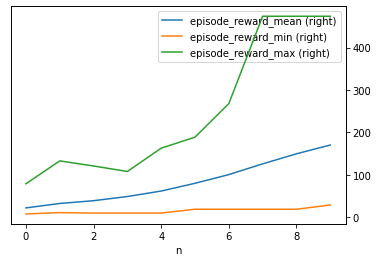

In [26]:
df.plot(x="n", y=["episode_reward_mean", "episode_reward_min", "episode_reward_max"], secondary_y=True);

In [27]:
import pprint
policy = agent.get_policy()
model = policy.model
pprint.pprint(model.variables())
pprint.pprint(model.value_function())
print(model.base_model.summary())

[<tf.Variable 'default_policy/fc_1/kernel:0' shape=(4, 100) dtype=float32>,
 <tf.Variable 'default_policy/fc_1/bias:0' shape=(100,) dtype=float32>,
 <tf.Variable 'default_policy/fc_value_1/kernel:0' shape=(4, 100) dtype=float32>,
 <tf.Variable 'default_policy/fc_value_1/bias:0' shape=(100,) dtype=float32>,
 <tf.Variable 'default_policy/fc_2/kernel:0' shape=(100, 50) dtype=float32>,
 <tf.Variable 'default_policy/fc_2/bias:0' shape=(50,) dtype=float32>,
 <tf.Variable 'default_policy/fc_value_2/kernel:0' shape=(100, 50) dtype=float32>,
 <tf.Variable 'default_policy/fc_value_2/bias:0' shape=(50,) dtype=float32>,
 <tf.Variable 'default_policy/fc_out/kernel:0' shape=(50, 2) dtype=float32>,
 <tf.Variable 'default_policy/fc_out/bias:0' shape=(2,) dtype=float32>,
 <tf.Variable 'default_policy/value_out/kernel:0' shape=(50, 1) dtype=float32>,
 <tf.Variable 'default_policy/value_out/bias:0' shape=(1,) dtype=float32>]
<tf.Tensor 'Reshape:0' shape=(?,) dtype=float32>
Model: "model"
________________

In [28]:
# hide
# # tuned training 
# %%time
# stop = {"episode_reward_mean": 195}
# analysis = ray.tune.run(
#   "PPO",
#   config=config,
#   stop=stop,
#   checkpoint_at_end=True,
# )

### Visualization after training


In [33]:
after_training = "after_training.mp4"
after_video = VideoRecorder(env, after_training)
observation = env.reset()
done = False
while not done:
  env.render()
  after_video.capture_frame()
  action = agent.compute_action(observation)
  observation, reward, done, info = env.step(action)
after_video.close()
env.close()
# You should get a video similar to the one below. 
html = render_mp4(after_training)
HTML(html)

2021-11-29 20:42:56,187	WARNING deprecation.py:39 -- DeprecationWarning: `compute_action` has been deprecated. Use `compute_single_action` instead. This will raise an error in the future!
